# Proteins - Sequence similarity

In [1]:
def get_all_clusters_at_threshold(threshold):
    all_clusters = []
    with open(f'clusters-by-entity-{threshold}.txt') as f:
         for cluster in f.readlines():
            cluster_list = cluster.split(' ')
            for index, item in enumerate(cluster_list):
                cluster_list[index] = cluster_list[index][0:4]
            all_clusters.append(cluster_list)
    return all_clusters

In [2]:
def pdb_list_txt_file_to_list(filename):
    pdbs = []
    with open(filename) as f:
        for line in f:
            pdbs.append(line[:4])
    return pdbs

In [6]:
def get_only_casf_clusters_at_threshold(threshold, casf_pdbs_filename):
    casf_pdbs_list = pdb_list_txt_file_to_list(casf_pdbs_filename)
    all_clusters = get_all_clusters_at_threshold(threshold)
    casf_only_clusters = {}
    for pdb in casf_pdbs_list:  
        while pdb not in casf_only_clusters:
            for i in all_clusters:
                if pdb.upper() in i:
                    casf_only_clusters[pdb] = i
                else:
                    continue
    return casf_only_clusters

In [7]:
def pdb_list_to_txt_file(file_name, pdb_list): 
    with open(file_name, 'w') as f:
        for p in pdb_list:
            f.write(p + '\n')

In [32]:
def remove_pdbs_in_casf_clusters(threshold, casf_pdbs_filename, pdbbind_pdbs_filename):
    pdbbind_pdbs = pdb_list_txt_file_to_list(pdbbind_pdbs_filename)
    casf_clusters = get_only_casf_clusters_at_threshold(threshold, casf_pdbs_filename)
    # Merges all values in dictionary into single list
    casf_clusters_merged = sum(casf_clusters.values(), [])
    new_pdbbind_pdbs = pdbbind_pdbs[:]
    for pdb in pdbbind_pdbs:
        if pdb.upper() in casf_clusters_merged:
            new_pdbbind_pdbs.remove(pdb)
    print(f'{len(new_pdbbind_pdbs)} structures are left after {threshold}% sequence similarity thresholding')
    new_pdbbind_pdbs_filename = pdbbind_pdbs_filename[:-4] + f'_sequence_threshold_{threshold}.txt'
    pdb_list_to_txt_file(new_pdbbind_pdbs_filename, new_pdbbind_pdbs)
    return None

In [33]:
remove_pdbs_in_casf_clusters(100, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

11998 structures are left after 100% sequence similarity thresholding


In [34]:
remove_pdbs_in_casf_clusters(90, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

11062 structures are left after 90% sequence similarity thresholding


In [35]:
remove_pdbs_in_casf_clusters(30, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

9208 structures are left after 30% sequence similarity thresholding


# Ligand (Tanimoto) Similarity

In [44]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

In [2]:
# https://www.macinchem.org/reviews/clustering/clustering.php

In [9]:
casf_pdbs = pdb_list_txt_file_to_list('casf_2016_ids.txt')
p = casf_pdbs[0]

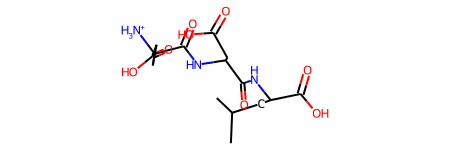

In [12]:
get_lig(p)

In [83]:
def get_lig(pdb_id):
    lig = next(Chem.SDMolSupplier(f'../pdbbind_2020_general/{pdb_id}/{pdb_id}_ligand.sdf'))
    if lig == None:
        lig = Chem.MolFromMol2File(f'../pdbbind_2020_general/{pdb_id}/{pdb_id}_ligand.mol2', removeHs=False)
    return lig

In [84]:
def generate_pdbbind_fingerprints(combined_pdbs):
    all_ligs = [get_lig(p) for p in combined_pdbs]
    return [AllChem.GetMorganFingerprintAsBitVect(x,2,2048) for x in all_ligs]

In [85]:
def cluster_pdbbind_fingerprints(pdbbind_pdbs_filename, casf_pdbs_filename, cutoff):
    pdbbind_pdbs = pdb_list_txt_file_to_list(pdbbind_pdbs_filename)
    casf_pdbs = pdb_list_txt_file_to_list(casf_pdbs_filename)
    combined_pdbs = pdbbind_pdbs+casf_pdbs
    fps = generate_pdbbind_fingerprints(combined_pdbs)
    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])
    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    # enumerate (pdbids) and the cs and then swap out the numbers so it has the pdbs in the lists for the clusters
    return convert_clusters_from_list_to_dictionary(cs, combined_pdbs)

In [86]:
def generate_pdbids_to_number_dict(pdbbind_pdbs):
    return {pdbbind_pdbs.index(pdb): pdb for pdb in pdbbind_pdbs}

In [87]:
def convert_clusters_from_list_to_dictionary(clusters, combined_pdbs):
    dict_ = generate_pdbids_to_number_dict(combined_pdbs)
    pdbid_clusters = []
    for i in range(len(clusters)):
        pdbid_clusters.append([dict_[j] for j in clusters[i]])
    return pdbid_clusters

In [88]:
def get_only_casf_clusters_at_tanimoto_similarity(threshold, casf_pdbs_filename, pdbbind_pdbs_filename):
    cutoff = 1 - (threshold/100)
    casf_pdbs_list = pdb_list_txt_file_to_list(casf_pdbs_filename)
    all_clusters = cluster_pdbbind_fingerprints(pdbbind_pdbs_filename, casf_pdbs_filename, cutoff)
    casf_only_clusters = {}
    for pdb in casf_pdbs_list: 
        if pdb not in casf_only_clusters:
            for i in all_clusters:
                if pdb in i:
                    casf_only_clusters[pdb] = i
                else:
                    continue
    return casf_only_clusters

In [89]:
def remove_pdbs_in_casf_clusters_tanimoto(threshold, casf_pdbs_filename, pdbbind_pdbs_filename):
    pdbbind_pdbs = pdb_list_txt_file_to_list(pdbbind_pdbs_filename)
    casf_clusters = get_only_casf_clusters_at_tanimoto_similarity(threshold, casf_pdbs_filename, pdbbind_pdbs_filename)
    # Merges all values in dictionary into single list
    casf_clusters_merged = sum(casf_clusters.values(), [])
    new_pdbbind_pdbs = pdbbind_pdbs[:]
    for pdb in pdbbind_pdbs:
        if pdb in casf_clusters_merged:
            new_pdbbind_pdbs.remove(pdb)
    print(f'{len(new_pdbbind_pdbs)} structures are left after {threshold}% tanimoto similarity thresholding')
    new_pdbbind_pdbs_filename = pdbbind_pdbs_filename[:-4] + f'_tanimoto_threshold_{threshold}.txt'
    pdb_list_to_txt_file(new_pdbbind_pdbs_filename, new_pdbbind_pdbs)
    return None

In [90]:
remove_pdbs_in_casf_clusters_tanimoto(100, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

14412 structures are left after 100% tanimoto similarity thresholding


In [91]:
remove_pdbs_in_casf_clusters_tanimoto(90, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

14324 structures are left after 90% tanimoto similarity thresholding


In [92]:
remove_pdbs_in_casf_clusters_tanimoto(30, 'casf_2016_ids.txt', 'pdbbind_2020_general_cleaned_ids_wout_undocked.txt')

9186 structures are left after 30% tanimoto similarity thresholding


# Both at same time

In [96]:
def get_intersection_of_two_sets(list1, list2):
    return list(set(list1) & set(list2))

In [97]:
def remove_pdbs_not_below_both_thresholds(threshold):
    tanimoto_list = pdb_list_txt_file_to_list(f'pdbbind_2020_general_cleaned_ids_wout_undocked_tanimoto_threshold_{threshold}.txt')
    sequence_list = pdb_list_txt_file_to_list(f'pdbbind_2020_general_cleaned_ids_wout_undocked_sequence_threshold_{threshold}.txt')
    both_list = get_intersection_of_two_sets(tanimoto_list, sequence_list)
    print(f'{len(both_list)} structures are left after {threshold}% tanimoto AND sequence similarity thresholding')
    pdb_list_to_txt_file(f'pdbbind_2020_general_cleaned_ids_wout_undocked_both_threshold_{threshold}.txt', both_list)
    return None

In [98]:
for i in 100, 90, 30:
    remove_pdbs_not_below_both_thresholds(i)

11706 structures are left after 100% tanimoto AND sequence similarity thresholding
10753 structures are left after 90% tanimoto AND sequence similarity thresholding
5904 structures are left after 30% tanimoto AND sequence similarity thresholding
